# Hedging Analysis using Jupyter Notebook

You are asked to maintain a pair trade of TQQQ long and QLD short so that over a period of 3 months the net profit is zero. You are constrained to the following:

Initial TQQQ long position has $1 million market value.
You can only rebalance the pair trade by trading QLD. That is, leave the TQQQ long position intact.
For rebalancing trade, you can only perform it at opening and/or closing auctions. That is, you can trade at most twice a day, and the price you get is either the open price or close price.
 
Present a quantitative analysis of different rebalancing strategies and make a recommendation.

You can get the open and close price data from Yahoo Finance.

In [114]:
## Import libraries
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import dateutil.relativedelta as relativedelta

tickets = ["TQQQ", "QLD"]

ticketsYF = yf.Tickers(tickets)

start_date = '2022-11-22'
rd = relativedelta.relativedelta(months = 3)
end_date = (datetime.strptime(start_date, "%Y-%m-%d") + rd).strftime("%Y-%m-%d")

dfRaw = ticketsYF.history(start=start_date, end=end_date)

[*********************100%***********************]  2 of 2 completed


In [115]:
dfRaw = dfRaw[["Open", "Close"]].unstack().to_frame()
dfRaw = dfRaw.reset_index().rename(columns = {0: "price", "level_0": "type", "level_1": "ticket", "Date": "date"})
dfRaw

,type,ticket,date,price
0,Open,QLD,2022-11-22,39.832974
1,Open,QLD,2022-11-23,40.760250
2,Open,QLD,2022-11-25,41.089283
3,Open,QLD,2022-11-28,40.431217
4,Open,QLD,2022-11-29,39.842945
...,...,...,...,...
239,Close,TQQQ,2023-02-14,25.490000
240,Close,TQQQ,2023-02-15,26.059999
241,Close,TQQQ,2023-02-16,24.570000
242,Close,TQQQ,2023-02-17,24.040001


In [116]:
dateHoursList = []
for row in range(len(dfRaw)):
    if dfRaw.loc[row, "type"] == "Open":
        dateHoursList.append(dfRaw.loc[row, "date"] + relativedelta.relativedelta(hours = 8))
    if dfRaw.loc[row, "type"] == "Close":
        dateHoursList.append(dfRaw.loc[row, "date"] + relativedelta.relativedelta(hours = 15))    

dfRaw["date_hour"] = dateHoursList

dfClean = dfRaw.set_index(["date_hour"])[["ticket", "price", "type"]]
dfClean

,ticket,price,type
date_hour,,,
2022-11-22 08:00:00,QLD,39.832974,Open
2022-11-23 08:00:00,QLD,40.760250,Open
2022-11-25 08:00:00,QLD,41.089283,Open
2022-11-28 08:00:00,QLD,40.431217,Open
2022-11-29 08:00:00,QLD,39.842945,Open
...,...,...,...
2023-02-14 15:00:00,TQQQ,25.490000,Close
2023-02-15 15:00:00,TQQQ,26.059999,Close
2023-02-16 15:00:00,TQQQ,24.570000,Close


In [117]:
dfCleanPivot = dfClean.pivot_table(index = "date_hour", columns = "ticket", values = "price")
dfCleanPivot

ticket,QLD,TQQQ
date_hour,,
2022-11-22 08:00:00,39.832974,21.219866
2022-11-22 15:00:00,40.760250,21.956045
2022-11-23 08:00:00,40.760250,21.936147
2022-11-23 15:00:00,41.567875,22.612637
2022-11-25 08:00:00,41.089283,22.224652
...,...,...
2023-02-16 15:00:00,44.669998,24.570000
2023-02-17 08:00:00,44.040001,24.030001
2023-02-17 15:00:00,44.029999,24.040001


<Axes: title={'center': 'Price time series [$]'}, xlabel='date_hour'>

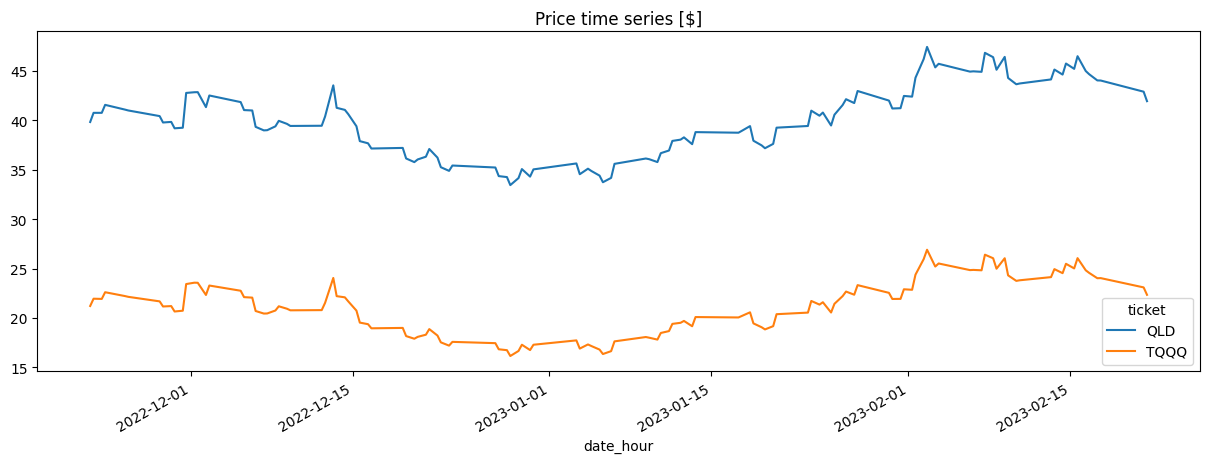

In [118]:
dfCleanPivot.plot(figsize = (15, 5), title = "Price time series [$]")

In [119]:
## For simplicity lets calculate arithmetic return

dfCleanTemp = dfClean.loc[dfClean["type"] == "Close"].pivot_table(index = "date_hour", columns = "ticket", values = "price")
dfReturns = (dfCleanTemp / dfCleanTemp.shift(1) - 1).dropna()
dfReturns.head()

ticket,QLD,TQQQ
date_hour,,
2022-11-23 15:00:00,0.019814,0.029905
2022-11-25 15:00:00,-0.013672,-0.020677
2022-11-28 15:00:00,-0.029669,-0.044025
2022-11-29 15:00:00,-0.014787,-0.023966
2022-11-30 15:00:00,0.091325,0.134328


<Axes: title={'center': 'Log. return time series [%]'}, xlabel='date_hour'>

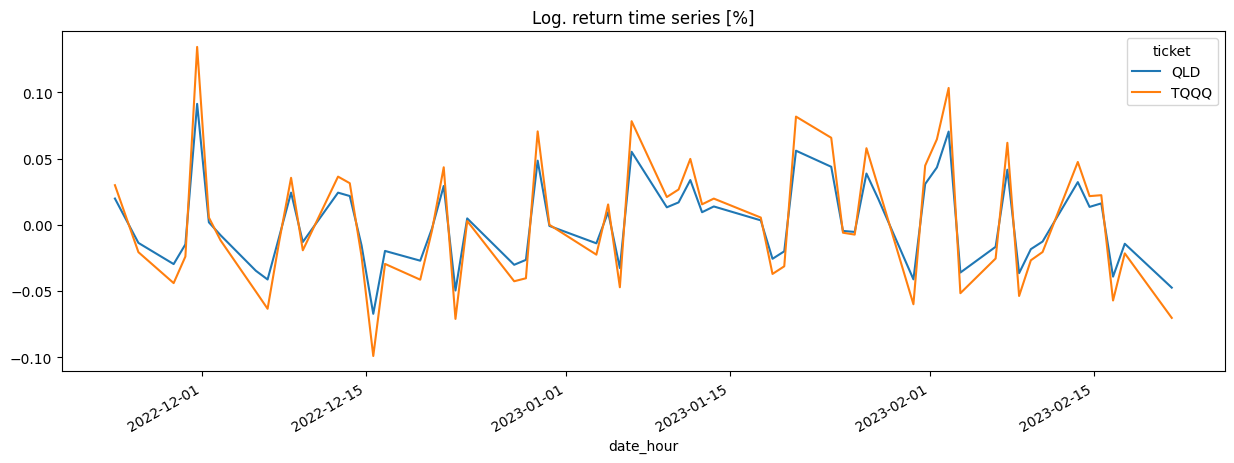

In [120]:
dfReturns.plot(figsize = (15,5), title = "Log. return time series [%]")

## First strategy: Buy and hold

In this case, based on the idea that TQQQ seeks to return X3 times the underlyin asset (Nasdaq-100 idex) and QLD does the same but X2 times, we will have this:

- $E[R_{TQQQ}] = E[3*R_{Nasdaq100}] = 3 E[R_{Nasdaq100}] = 3 \overline{R_{Nasdaq100}}$
- $E[R_{QLD}] = E[2*R_{Nasdaq100}] = 2 E[R_{Nasdaq100}] = 2 \overline{R_{Nasdaq100}}$

At the end, we got a portfolio:

- $E[R_{port}] = E[w_{TQQQ} * R_{TQQQ} + w_{QLD} * R_{QLD}] = w_{TQQQ} * 3 \overline{R_{Nasdaq100}} + w_{QLD} * 2 \overline{R_{Nasdaq100}} = 0$

So, in this case we got a solutions assuming no leverage ($w_{TQQQ} + w_{QLD} = 100%$):

- $w_{TQQQ} = -200\%$ and $w_{QLD} = 300\%$, that could looks counterintuitive but if we look, the entire portfolio has a negative value (short value), that will explane why $-200\%$ means a long position and $300\%$ means a short one.

Based on previous weights be got:
- $\text{initValTQQQ} = \$1.000.000$
- $\text{initValQLD} = -\$1.500.000$ 

Given the returns of each asset, we can construct a performance attribution based on this calculations:

Valuation of assets
- $\text{ValTQQQ [}\$\text{]}_{t} = \text{ValTQQQ [}\$\text{]}_{t - 1} * R_{TQQQ, t}$
- $\text{ValQLD [}\$\text{]}_{t} = \text{ValQLD [}\$\text{]}_{t - 1} * R_{QLD, t}$
- $\text{ValPort [}\$\text{]}_{t} = \text{ValTQQQ [}\$\text{]}_{t} + \text{ValQLD [}\$\text{]}_{t}$

Return of portfolio
- $\text{RetPort [}\$\text{]}_{t} = \dfrac{\text{ValPort [}\$\text{]}_{t}}{\text{ValPort [}\$\text{]}_{t - 1}} - 1 = \text{Contr TQQQ}_{t} + \text{Contr QLD}_{t} $

Weights (Participation)
- $ w_{TQQQ, t} = \dfrac{\text{ValTQQQ [}\$\text{]}_{t}}{\text{ValPort [}\$\text{]}_{t}}$
- $ w_{QLD, t} = \dfrac{\text{ValQLD [}\$\text{]}_{t}}{\text{ValPort [}\$\text{]}_{t}}$

Contribution
- $\text{Contr TQQQ}_{t} = \text{RetPort [}\$\text{]}_{t} * w_{TQQQ, t}$
- $\text{Contr QLD}_{t} = \text{RetPort [}\$\text{]}_{t} * w_{QLD, t}$


<Axes: title={'center': 'cumulative return time series [%]'}, xlabel='date_hour'>

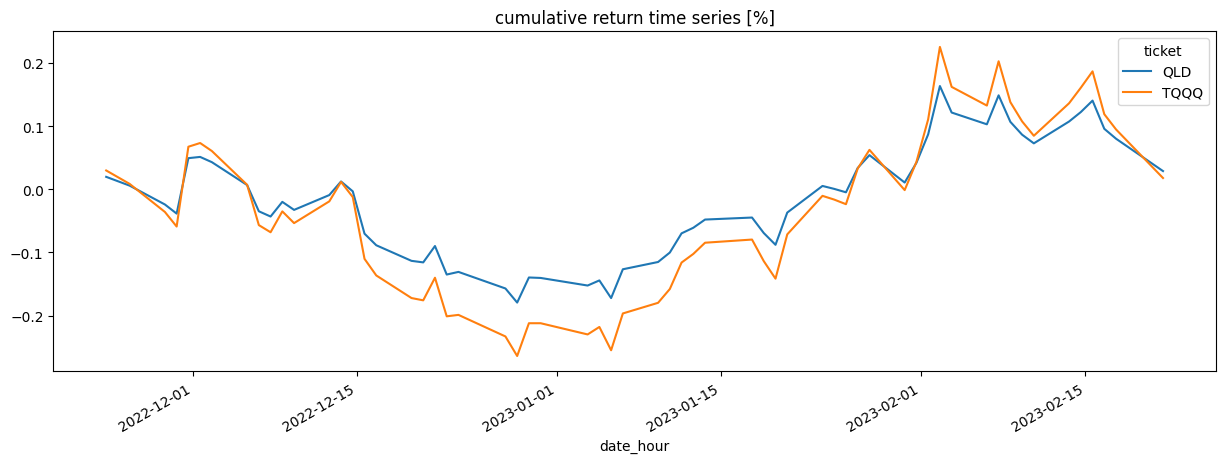

In [121]:
## Initial Investment per asset

initValTQQQ = 1000000
initValQLD = -1500000

dfCompRet = (dfReturns + 1).cumprod() - 1
dfCompRet.plot(figsize = (15, 5), title = "cumulative return time series [%]")

<Axes: title={'center': 'Value time series [$]'}, xlabel='date_hour'>

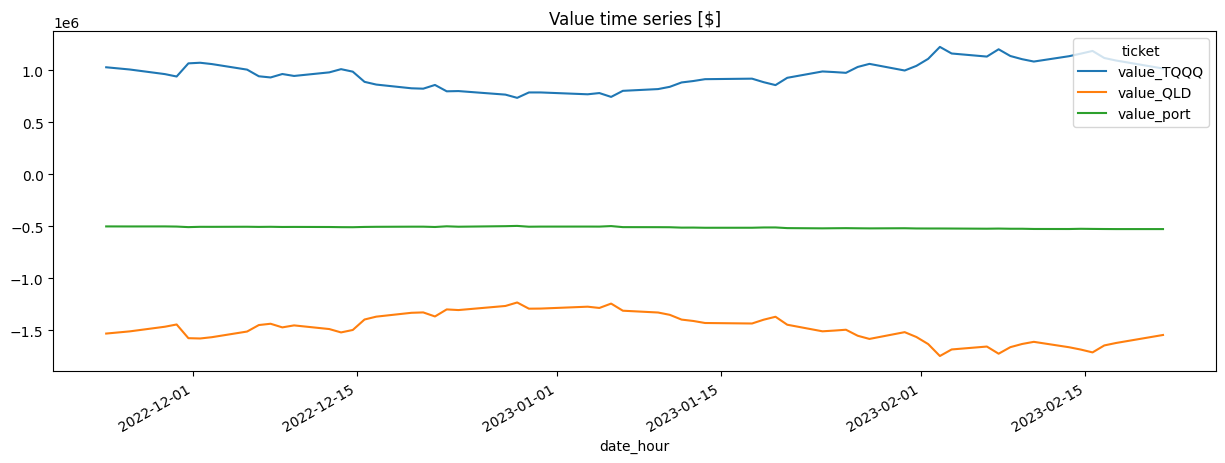

In [122]:
# Value of investment in time
dfValue = dfCompRet.copy()
dfValue["value_TQQQ"] = initValTQQQ * (dfCompRet["TQQQ"] + 1)
dfValue["value_QLD"] = initValQLD * (dfCompRet["QLD"] + 1)
dfValue["value_port"] = dfValue["value_TQQQ"] + dfValue["value_QLD"]

dfValue[["value_TQQQ", "value_QLD", "value_port"]].plot(figsize = (15, 5), title = "Value time series [$]")

In [123]:
dfValue.tail()

ticket,QLD,TQQQ,value_TQQQ,value_QLD,value_port
date_hour,,,,,
2023-02-14 15:00:00,0.122417,0.160956,1.160956e+06,-1.683626e+06,-522669.704968
2023-02-15 15:00:00,0.140572,0.186917,1.186917e+06,-1.710858e+06,-523941.234959
2023-02-16 15:00:00,0.095921,0.119054,1.119054e+06,-1.643881e+06,-524826.936652
2023-02-17 15:00:00,0.080219,0.094915,1.094915e+06,-1.620329e+06,-525413.683399
2023-02-21 15:00:00,0.028944,0.017943,1.017943e+06,-1.543415e+06,-525472.500983


In [124]:
dfWeights = pd.DataFrame(index = dfValue.index)
dfWeights["QLD"] = dfValue["value_QLD"] / (dfValue["value_port"])
dfWeights["TQQQ"] = dfValue["value_TQQQ"] / (dfValue["value_port"])
dfWeights.tail()

,QLD,TQQQ
date_hour,,
2023-02-14 15:00:00,3.221204,-2.221204
2023-02-15 15:00:00,3.265363,-2.265363
2023-02-16 15:00:00,3.132234,-2.132234
2023-02-17 15:00:00,3.083910,-2.083910
2023-02-21 15:00:00,2.937195,-1.937195


<Axes: title={'center': 'Performance attribution - Cumulative return [%]'}, xlabel='date_hour'>

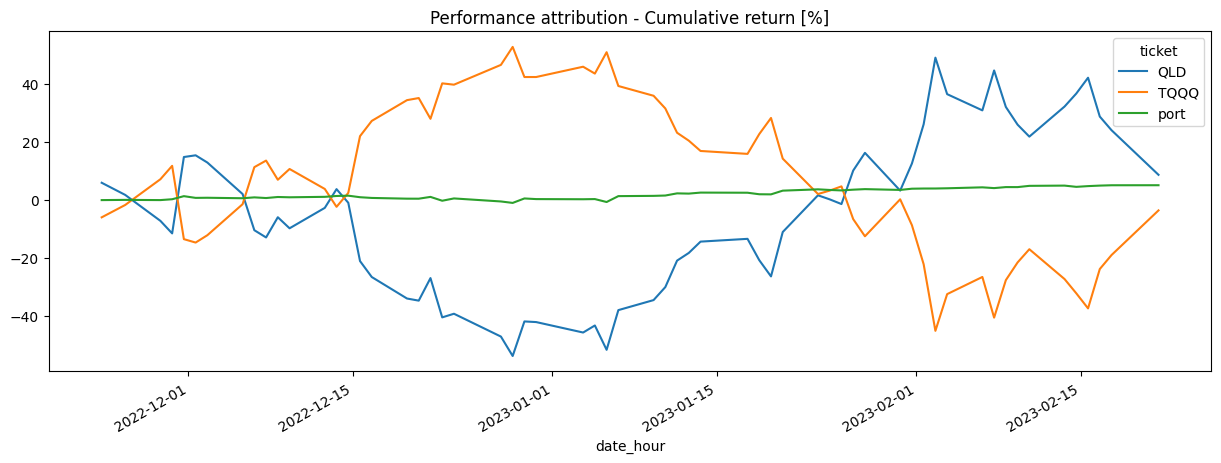

In [125]:
initialWeights = [initValQLD / (initValQLD + initValTQQQ), initValTQQQ / (initValQLD + initValTQQQ)]

dfCompRetPort = dfCompRet.copy()
dfCompRetPort["QLD"] = dfCompRetPort["QLD"] * initialWeights[0]
dfCompRetPort["TQQQ"] = dfCompRetPort["TQQQ"] * initialWeights[1]
dfCompRetPort["port"] = dfCompRetPort["QLD"] + dfCompRetPort["TQQQ"]

(dfCompRetPort * 100).plot(figsize = (15, 5), title = "Performance attribution - Cumulative return [%]")

In [126]:
(dfCompRetPort * 100).tail()

ticket,QLD,TQQQ,port
date_hour,,,
2023-02-14 15:00:00,36.725117,-32.191176,4.533941
2023-02-15 15:00:00,42.171613,-37.383366,4.788247
2023-02-16 15:00:00,28.776183,-23.810796,4.965387
2023-02-17 15:00:00,24.065716,-18.982979,5.082737
2023-02-21 15:00:00,8.683081,-3.588581,5.094500


With the "buy-and-hold" strategy, we obtain 5.09% return (2023-02-21). Despite the fact we assume that both assets track the same underlying when we calculate a rolling window correlation we see that it is not always -1, and the same happends with the covariance and portfolio variance.

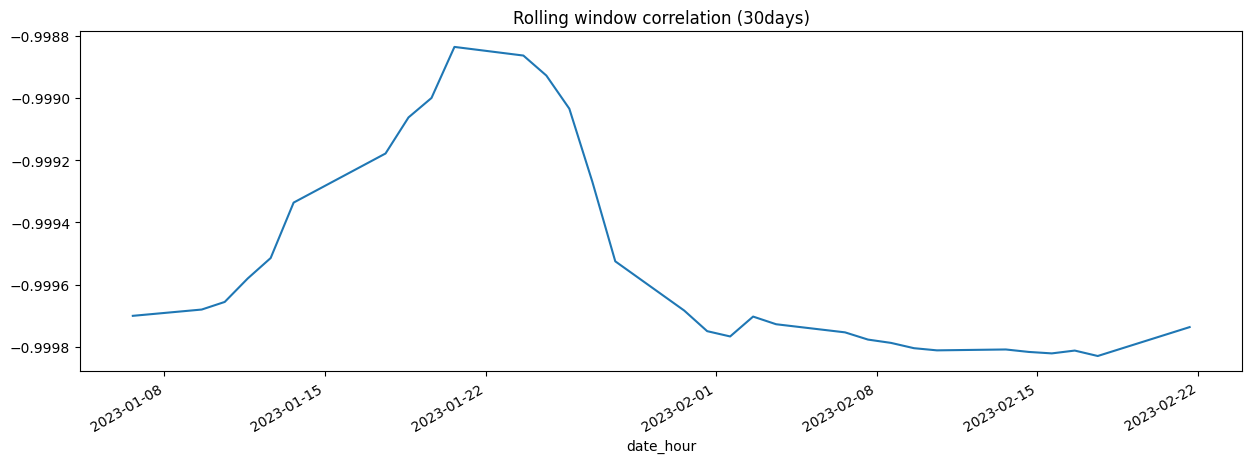

In [127]:
ax = dfCompRetPort["TQQQ"].rolling(30).corr(dfCompRetPort["QLD"]).plot(figsize = (15, 5), title = "Rolling window correlation (30days)")

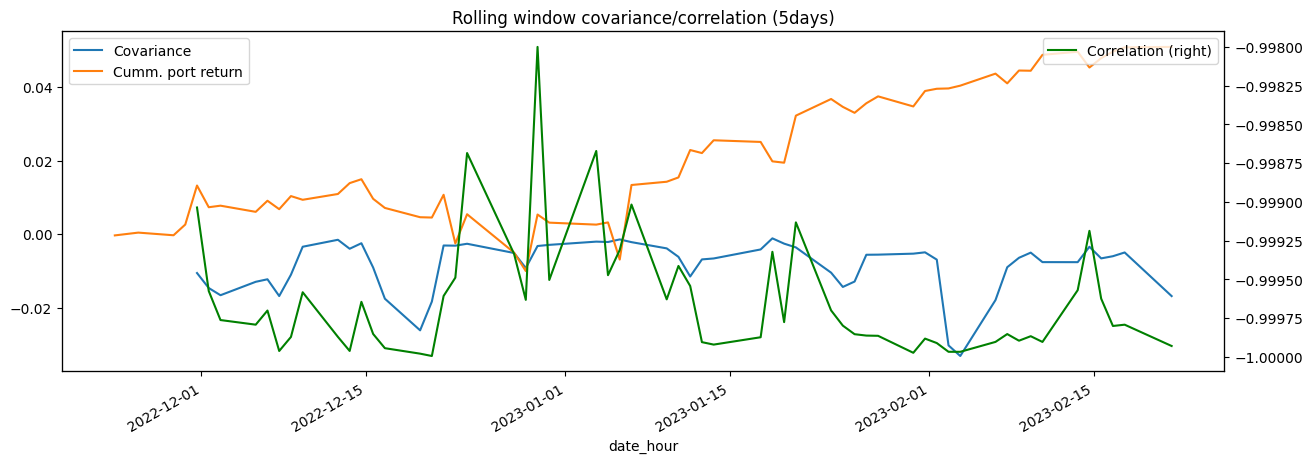

In [128]:
ax = dfCompRetPort["TQQQ"].rolling(5).cov(dfCompRetPort["QLD"]).plot(figsize = (15, 5), title = "Rolling window covariance/correlation (5days)", label = "Covariance")
ax = dfCompRetPort["port"].plot(figsize = (15, 5), label = "Cumm. port return")
ax2 = ax.twinx()
ax2 = dfCompRetPort["TQQQ"].rolling(5).corr(dfCompRetPort["QLD"]).plot(figsize = (15, 5),secondary_y=True, label = "Correlation", color = "green")
ax.legend(loc = 2)
ax2.legend(loc = 1)

<Axes: title={'center': 'Price time series [$]'}, xlabel='date_hour'>

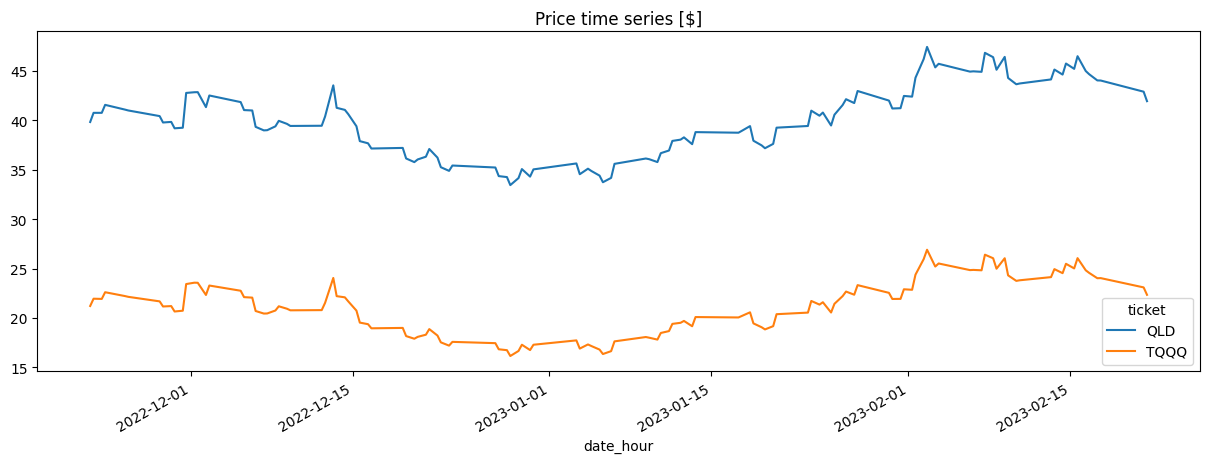

In [129]:
dfCleanPivot.plot(figsize = (15, 5), title = "Price time series [$]")

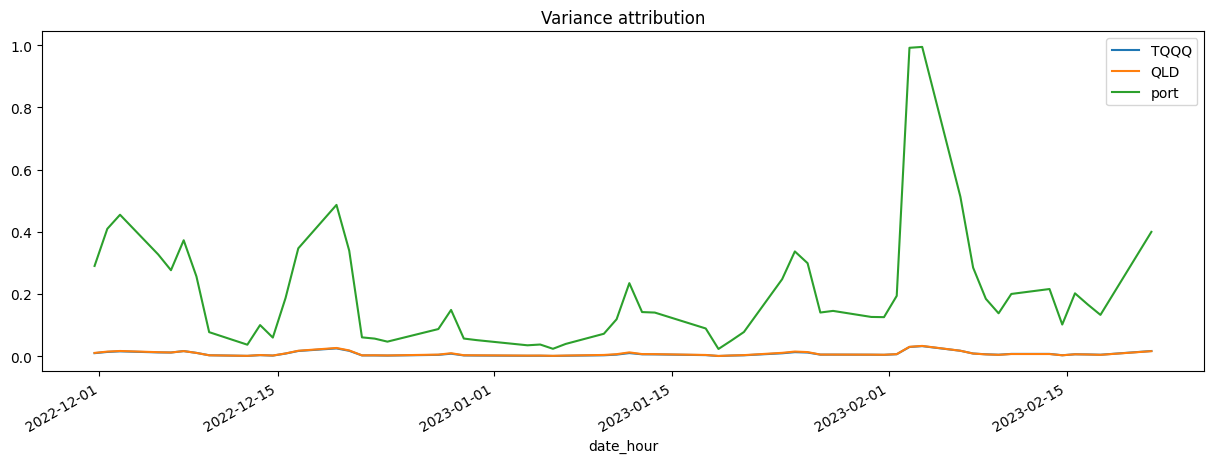

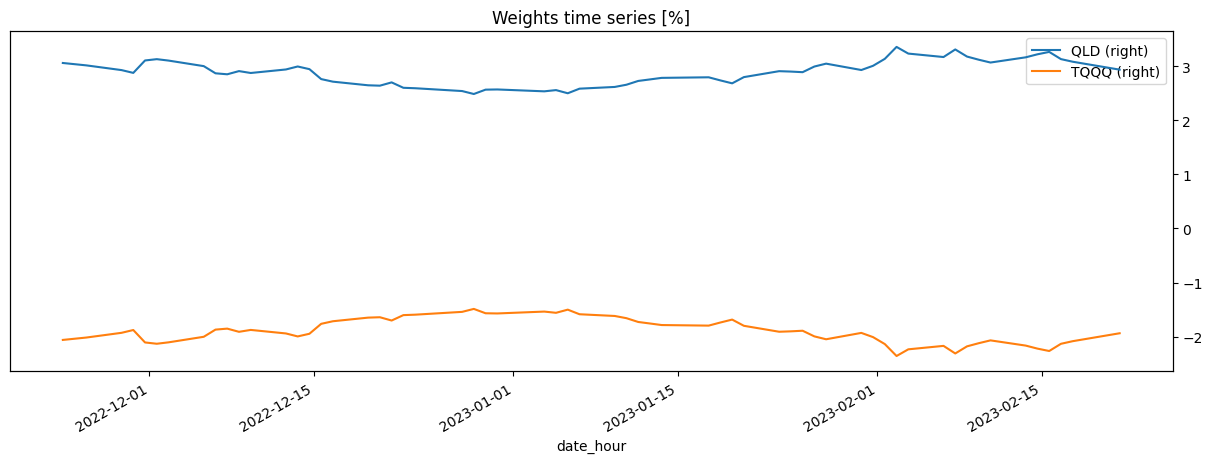

In [130]:
dfVariance = pd.DataFrame(index = dfCompRetPort.index)
dfVariance["TQQQ"] = (dfCompRetPort["TQQQ"].rolling(5).std())**2
dfVariance["QLD"] = (dfCompRetPort["QLD"].rolling(5).std())**2
dfVariance["port"] = (dfWeights["TQQQ"]**2) * dfVariance["TQQQ"] + (dfWeights["QLD"]**2) * dfVariance["QLD"] + 2 * dfWeights["TQQQ"] * dfWeights["QLD"] * (dfCompRetPort["TQQQ"].rolling(5).cov(dfCompRetPort["QLD"]))
ax = dfVariance.plot(figsize = (15,5), title = "Variance attribution")

ax = dfWeights.plot(secondary_y=True, figsize = (15,5) , title = "Weights time series [%]")


## Conclusion Buy-and-Hold strategy

Based on this strategy, despite the fact the expected return of this portfolio was 0, we saw how between 2022-11-22 and 2023-02-21 we obtained a 5.09% of return (value portfolio was -\$500.000 and finished -\$525.472). This could be explained that we have 2 different underlyings (2 not perfect Nasdaq100 index composition).

## RSI Strategy

As we saw on cumulative return, the portfolio start creating a positive return after the first week of January, when the cumulative return of QLD started increasing, so the intuition behind this is that if the proportion of QLD inside the portfolio increase (a decrease on USD), we need to reduce its proportion (an increase on USD), reducing the short size of QLD, buy QLD stocks.

Because of that I propose a simple strategy based on a comparison between RSI indexes of QLD and TQQQ.

- If $RSA_{QLD} - RSI_{TQQQ} > 0$ &rarr; **BUY QLD** &rarr; **Reduce QLD proportion** &rarr; **Increase USD value**
- If $RSA_{QLD} - RSI_{TQQQ} < 0$ &rarr; **SELL QLD** &rarr; **Increase QLD proportion** &rarr; **Decrease USD value**

Finally, based on an empirical approximation, we define the size of the purchase like this:

$$(RSA_{QLD} - RSI_{TQQQ}) * 20pbs * abs(\text{initValQLD})$$





In [131]:
dfRSI = dfReturns.copy()
dfRSI['gain_QLD'] = dfRSI["QLD"].mask(dfRSI["QLD"] < 0, 0.0)
dfRSI['loss_QLD'] = -dfRSI["QLD"].mask(dfRSI["QLD"] > 0, -0.0)

dfRSI['gain_TQQQ'] = dfRSI["TQQQ"].mask(dfRSI["TQQQ"] < 0, 0.0)
dfRSI['loss_TQQQ'] = -dfRSI["TQQQ"].mask(dfRSI["TQQQ"] > 0, -0.0)


def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)
    a[n] = x[1:n+1].mean()
    for i in range(n+1, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

dfRSI['avg_gain_QLD'] = rma(dfRSI['gain_QLD'].to_numpy(), 14)
dfRSI['avg_loss_QLD'] = rma(dfRSI['loss_QLD'].to_numpy(), 14)

dfRSI['avg_gain_TQQQ'] = rma(dfRSI['gain_TQQQ'].to_numpy(), 14)
dfRSI['avg_loss_TQQQ'] = rma(dfRSI['loss_TQQQ'].to_numpy(), 14)

dfRSI['rs_QLD'] = dfRSI['avg_gain_QLD'] / dfRSI['avg_loss_QLD']
dfRSI['rsi_QLD'] = 100 - (100 / (1 + dfRSI['rs_QLD']))

dfRSI['rs_TQQQ'] = dfRSI['avg_gain_TQQQ'] / dfRSI['avg_loss_TQQQ']
dfRSI['rsi_TQQQ'] = 100 - (100 / (1 + dfRSI['rs_TQQQ']))
dfRSI["rsi_QLD_TQQQ"] = dfRSI['rsi_QLD'] - dfRSI['rsi_TQQQ']
dfRSI.tail()

ticket,QLD,TQQQ,gain_QLD,loss_QLD,gain_TQQQ,loss_TQQQ,avg_gain_QLD,avg_loss_QLD,avg_gain_TQQQ,avg_loss_TQQQ,rs_QLD,rsi_QLD,rs_TQQQ,rsi_TQQQ,rsi_QLD_TQQQ
date_hour,,,,,,,,,,,,,,,
2023-02-14 15:00:00,0.013514,0.021643,0.013514,0.000000,0.021643,0.000000,0.017221,0.010572,0.025550,0.015638,1.628959,61.962135,1.633850,62.032771,-0.070636
2023-02-15 15:00:00,0.016175,0.022362,0.016175,0.000000,0.022362,0.000000,0.017147,0.009817,0.025322,0.014521,1.746650,63.592012,1.743848,63.554832,0.037181
2023-02-16 15:00:00,-0.039148,-0.057176,0.000000,0.039148,0.000000,0.057176,0.015922,0.011912,0.023514,0.017568,1.336627,57.203269,1.338453,57.236691,-0.033422
2023-02-17 15:00:00,-0.014327,-0.021571,0.000000,0.014327,0.000000,0.021571,0.014785,0.012084,0.021834,0.017854,1.223434,55.024531,1.222944,55.014603,0.009929
2023-02-21 15:00:00,-0.047468,-0.070300,0.000000,0.047468,0.000000,0.070300,0.013729,0.014612,0.020274,0.021600,0.939547,48.441575,0.938640,48.417457,0.024118


In [132]:
dfPurchases = pd.DataFrame(columns=["value_QLD"])
dfPurchases["value_QLD"] = (dfRSI["rsi_QLD_TQQQ"] * 0.002 * abs(initValQLD)).fillna(0)
dfPurchases.tail()

,value_QLD
date_hour,
2023-02-14 15:00:00,-211.908796
2023-02-15 15:00:00,111.541816
2023-02-16 15:00:00,-100.266385
2023-02-17 15:00:00,29.786332
2023-02-21 15:00:00,72.354305


In [133]:
dfPurchases.describe(())

,value_QLD
count,60.000000
mean,203.050712
std,550.365841
min,-725.454985
50%,0.000000
max,1598.607149


<Axes: title={'center': 'Value time series [$] RSI Strategy'}, xlabel='date_hour'>

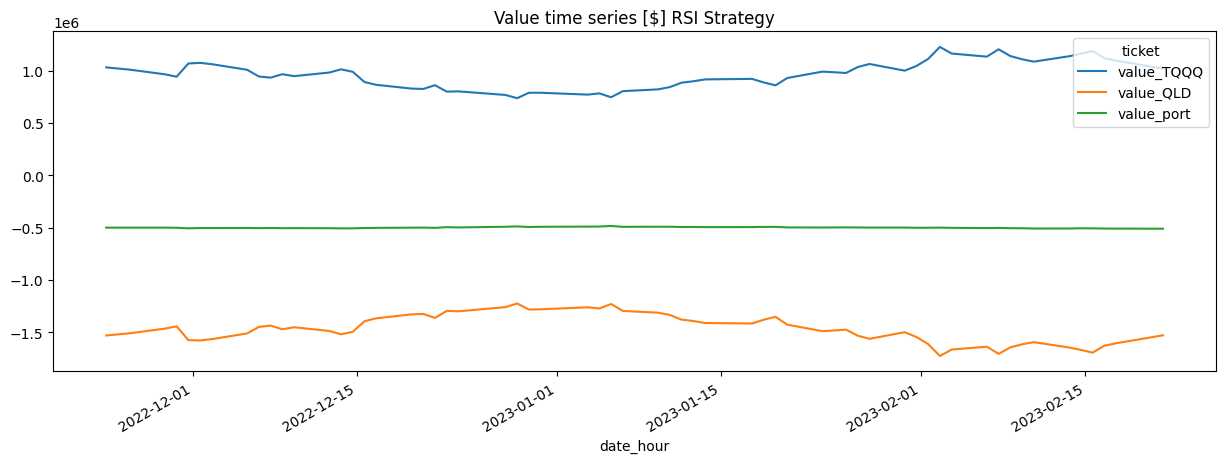

In [134]:
# Value of investment in time
dfValueRSI = dfCompRet.copy()
dfValueRSI["value_TQQQ"] = initValTQQQ * (dfCompRet["TQQQ"] + 1)
listValQLD_RSI = [initValQLD]

for i, date in enumerate(dfReturns.index):
    listValQLD_RSI.append(listValQLD_RSI[-1] * (1 + dfReturns.loc[date, "QLD"]) + dfPurchases.loc[date, "value_QLD"])

listValQLD_RSI.pop(0)
    
dfValueRSI["value_QLD"] = listValQLD_RSI
dfValueRSI["value_port"] = dfValueRSI["value_TQQQ"] + dfValueRSI["value_QLD"]

dfValueRSI[["value_TQQQ", "value_QLD", "value_port"]].plot(figsize = (15, 5), title = "Value time series [$] RSI Strategy")

<Axes: title={'center': 'Cumulative return [%] - RSI Strategy'}, xlabel='date_hour'>

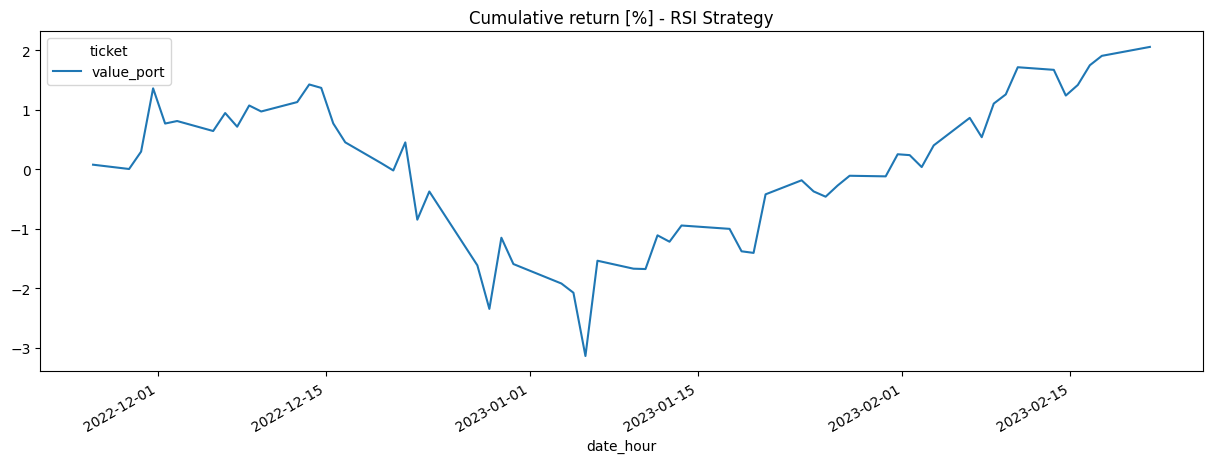

In [135]:
dfReturnsRSI = dfValueRSI[["value_port"]].pct_change().dropna()
dfCompRetRSI = (dfReturnsRSI + 1).cumprod() - 1
(dfCompRetRSI * 100).plot(figsize = (15, 5), title = "Cumulative return [%] - RSI Strategy")

In [136]:
(dfCompRetRSI * 100).tail()

ticket,value_port
date_hour,
2023-02-14 15:00:00,1.237454
2023-02-15 15:00:00,1.415595
2023-02-16 15:00:00,1.746403
2023-02-17 15:00:00,1.904508
2023-02-21 15:00:00,2.054497


## Conclusions RSI strategy

With this strategy, we reduce the cumulative return of the portfolio from 5.09% to 2.05%.